In [7]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical
from data import data_dirs as data_env
import data

from result_visualization import show_results

from fastai.vision import (
    learner,
    Learner, load_learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType,
    plt,   # matplotlib.pyplot
    nn,    # torch.nn
    optim  # torch.optim
)
from fastai.callbacks.mem import PeakMemMetric

from model import (
    decoder_high_output, decoder_middle_output, decoder_first_output,
    encoder_low_output, encoder_middle_output, encoder_first_output,
    LinkNet34, pre_encoder_output
)

from torchvision.utils import save_image

import cv2

import numpy as np

import imageio
from pathlib import Path

import torch
torch.set_printoptions(precision=7, sci_mode=False)

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [64]:
imgs, lbls = [], []
for img in data.data_dirs.get_subdir("test iPhoneXR images without labels").iterdir():
    imgs += [open_image(img, after_open=lambda x: x.resize([256, 256]))]
    
model = learner.load_learner("/home/dmitri/Documents/model_weights/linknet34/", "linknet34_const_full_e25_exp_without_logit_1e-03")
pred_mask, torch_mask, _ = model.predict(imgs[4])

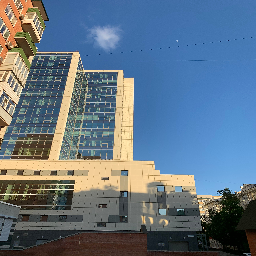

In [65]:
imgs[4]

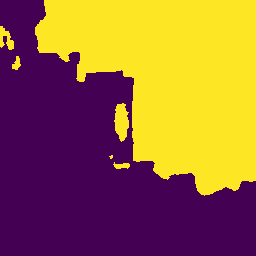

In [66]:
save_image(torch_mask.to(float), "/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/find_contr/image_mask.png")
pred_mask

In [69]:
AREA_THRESHOLD = 600

torch_mask *= 255
lable_np_array = torch_mask.numpy()
    
blur = cv2.GaussianBlur(lable_np_array.astype(np.uint8),(5,5),0).squeeze(0)
ret,thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Contour detection
_, contours, hierarchy = cv2.findContours( thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter contour by area
contour_list = []
area_threshold = AREA_THRESHOLD

for contour in contours:
    area = cv2.contourArea(contour)
    if area > area_threshold :
        contour_list.append(contour)

# Making binary mask by contour        
countMask = np.zeros(thresh.shape, dtype='uint8')
cv2.drawContours(countMask, contour_list, -1, (255, 255, 255), cv2.FILLED)

# Restore accuracy of board between sky and other objects
mask_rev = np.add(cv2.bitwise_not(thresh), cv2.bitwise_not(countMask))
_,mask_rev = cv2.threshold(mask_rev, 0, 255, cv2.THRESH_BINARY)
mask = cv2.bitwise_not(mask_rev) 

save_image(torch.from_numpy(mask).to('cpu', torch.float), 
           "/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/find_contr/image_mask_after_correction.png")

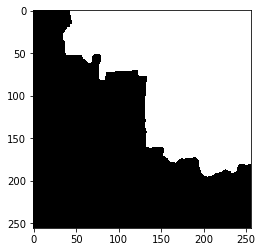

In [70]:
plt.figure()
plt.imshow(cv2.bitwise_not(mask), cmap="Greys")